In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import factorial
import scipy.stats as stats 
from scipy.stats import poisson
import math as m
from sklearn.cluster import KMeans

In [2]:
df = pd.read_table('pmm_q1.tsv', header=None)
x = df.iloc[:, 0].to_numpy()
n = x.shape[0]

In [3]:
# Number of mixture components
K = 3

#Gibbs burnin
burn = 1000

# init via k-means
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(np.reshape(x, (-1, 1)))
z = kmeans.labels_
l = kmeans.cluster_centers_.flatten().tolist()

pis = np.zeros((3,))
for k in range(K):
    pis[k] = np.sum(kmeans.labels_ == k) / n

# Samples
S = 2000
l_s = np.zeros((3, S))
pi_s = np.zeros((3, S))

# Setting up the parameter update step(s)
alpha = 2 * np.ones((3,))
eta = 2 * np.ones((3,))
beta = 2 * np.ones((3,))

alpha_new = np.zeros((3,))

print("Initial params: ")
print(l)
print(pis)
print("\n")

w = np.zeros((n, K))

# Setting up the datastructures for the plots ... lots of plots that are easier to do in R
pi_trace =  np.zeros((S, K)) 
lambda_trace = np.zeros((S, K))

for i in range(S + burn): 

    # re-sample z
    for k in range(K):
        w[:, k] = pis[k] * poisson.pmf(x, l[k])
    w /= w.sum(axis=1)[:, None]

    for s in range(n):
        z[s] = np.random.choice(K, p=w[s])
  
    # sample pi & lambda
    for k in range(K):
        alpha_new[k] = alpha[k] + (np.sum(z == k))
        l[k] = np.random.gamma(eta[0] + np.sum(x[z == k]), 1/(beta[0] + np.sum(z == k)))
    pis = np.random.dirichlet(alpha_new)
    
    
    # Start sampling after burn-in
    if (i >= burn):
        for k in range(K):
            l_s[k, i-burn] = l[k]
            pi_s[k, i-burn] = pis[k]
            pi_trace[i-burn, k] = pis[k]
            lambda_trace[i-burn, k] = l[k]
    
print("Final params: ")
print(l)
print(pis)

c:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Initial params: 
[0.8705440900562857, 14.353932584269668, 6.830449826989621]
[0.533 0.178 0.289]


Final params: 
[0.8123714251062889, 12.555219488593876, 5.214138727143895]
[0.47306763 0.2780583  0.24887407]


Text(0, 0.5, 'lambda 1')

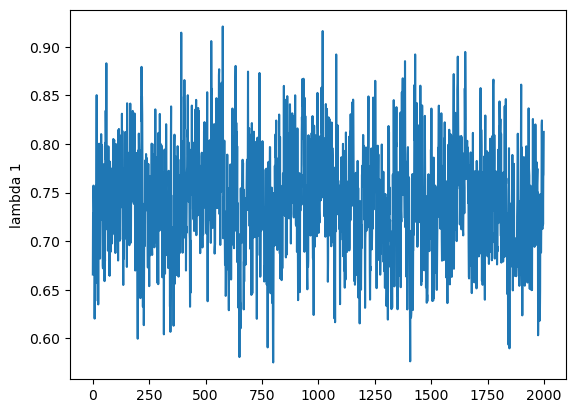

In [4]:
# No good API for traceplots in Python, let me tell you.
plt.plot(np.arange(0, S, 1), lambda_trace[:,0])
plt.ylabel("lambda 1")

Text(0, 0.5, 'lambda 2')

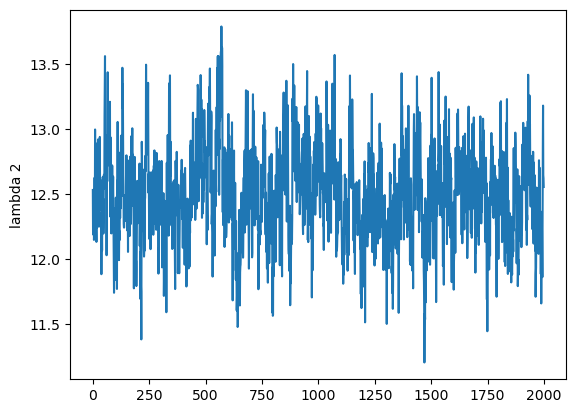

In [5]:
plt.plot(np.arange(0, S, 1), lambda_trace[:,1])
plt.ylabel("lambda 2")

Text(0, 0.5, 'lambda 3')

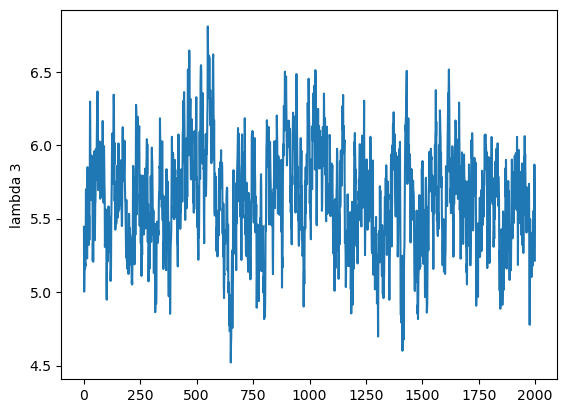

In [6]:
plt.plot(np.arange(0, S, 1), lambda_trace[:,2])
plt.ylabel("lambda 3")

Text(0, 0.5, 'pi 1')

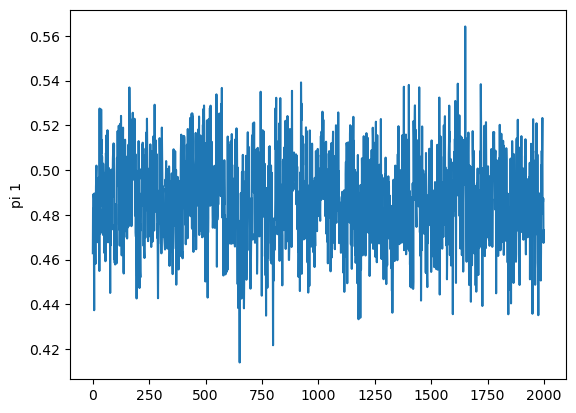

In [7]:
plt.plot(np.arange(0, S, 1), pi_trace[:,0])
plt.ylabel("pi 1")

Text(0, 0.5, 'pi 2')

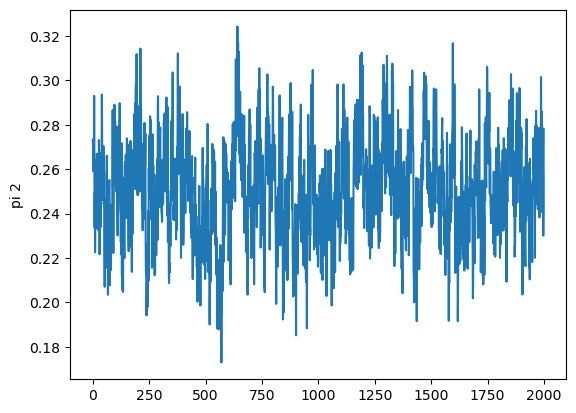

In [8]:
plt.plot(np.arange(0, S, 1), pi_trace[:,1])
plt.ylabel("pi 2")

Text(0, 0.5, 'pi 3')

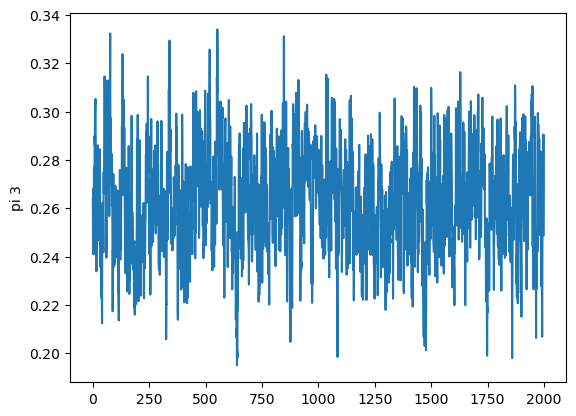

In [9]:
plt.plot(np.arange(0, S, 1), pi_trace[:,2])
plt.ylabel("pi 3")

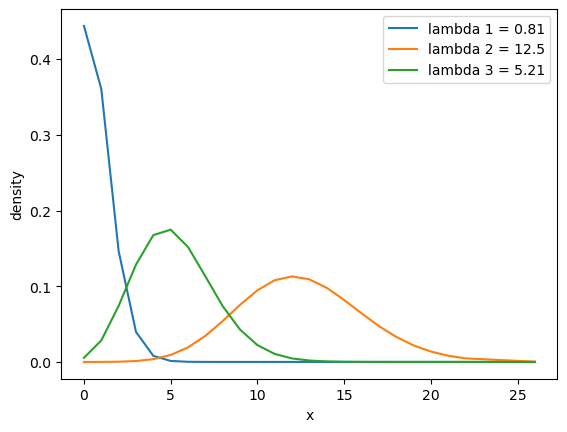

In [10]:
x_ = np.unique(x)
y1 = poisson.pmf(x_, mu=l[0])
y2 = poisson.pmf(x_, mu=l[1])
y3 = poisson.pmf(x_, mu=l[2])
s1="lambda 1 = " + str(l[0])[0:4]
s2="lambda 2 = " + str(l[1])[0:4]
s3="lambda 3 = " + str(l[2])[0:4]
plt.plot(x_, y1, label=s1)
plt.plot(x_, y2, label=s2)
plt.plot(x_, y3, label=s3)
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()



In [11]:
# Credible interval(s)
pi_interval = np.zeros((3,3))
lambda_interval = np.zeros((3,3))

"""
specifies the value of the random variable such that the probability of the variable being
less than or equal to that value equals the given probability. 
-wikipedia
"""

for k in range(K): 
    lambda_interval[k] = np.quantile(lambda_trace[:,k], [0.025, 0.5, 0.975])
    pi_interval[k] = np.quantile(pi_trace[:,k], [0.025, 0.5, 0.975])

ci_lambda = pd.DataFrame(lambda_interval)  
ci_lambda.columns = ['0.025', '0.5', '0.975']
ci_lambda

,0.025,0.5,0.975
0,0.636180,0.740930,0.847715
1,11.804450,12.489490,13.257312
2,4.960917,5.632206,6.300783


In [12]:
ci_pi = pd.DataFrame(pi_interval)  
ci_pi.columns = ['0.025', '0.5', '0.975']
ci_pi

,0.025,0.5,0.975
0,0.449062,0.486995,0.522829
1,0.206630,0.250195,0.296320
2,0.221376,0.262535,0.303874


c:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\denni\anaconda3\envs\bioinformatics\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'lambda 1')

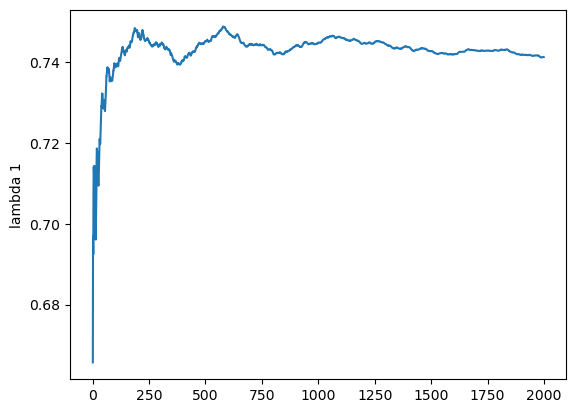

In [13]:
# Running average
running_average_pi = np.zeros((K, S))
running_average_lambda = np.zeros((K, S))
for k in range(K):
  for i in range(S):
    running_average_pi[k, i] = np.mean(pi_trace[0:i, k])
    running_average_lambda[k, i] = np.mean(lambda_trace[0:i, k])
  

plt.plot(np.arange(S), running_average_lambda[0,:])
plt.ylabel("lambda 1")

Text(0, 0.5, 'lambda 2')

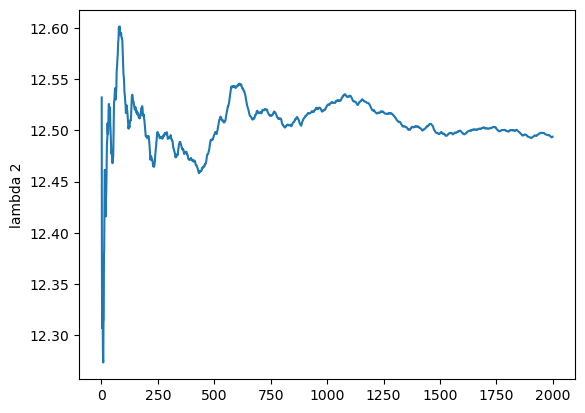

In [14]:
plt.plot(np.arange(S), running_average_lambda[1,:])
plt.ylabel("lambda 2")

Text(0, 0.5, 'lambda 3')

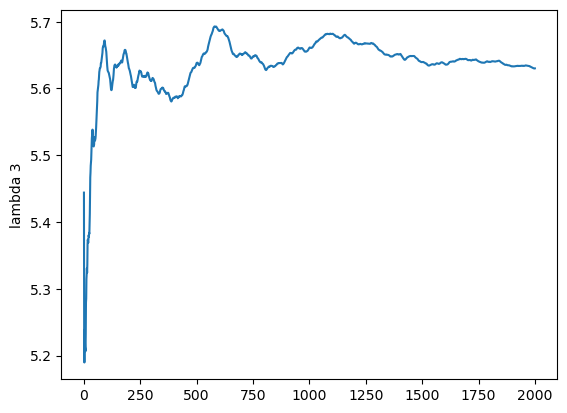

In [15]:
plt.plot(np.arange(S), running_average_lambda[2,:])
plt.ylabel("lambda 3")

Text(0, 0.5, 'pi 1')

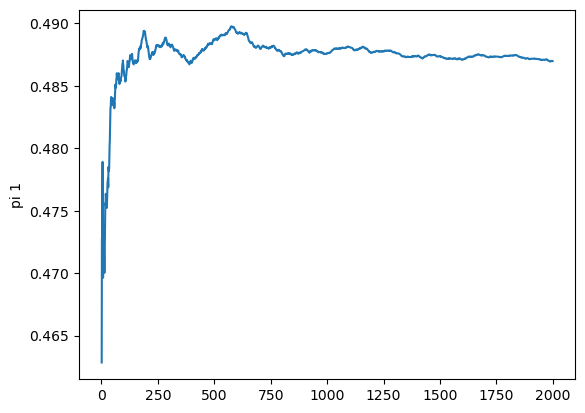

In [16]:
plt.plot(np.arange(S), running_average_pi[0,:])
plt.ylabel("pi 1")

Text(0, 0.5, 'pi 2')

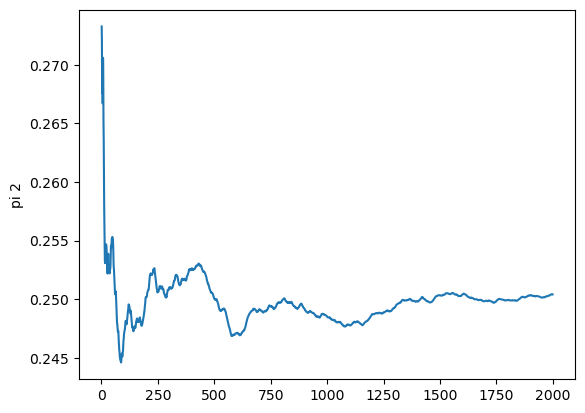

In [17]:
plt.plot(np.arange(S), running_average_pi[1,:])
plt.ylabel("pi 2")

Text(0, 0.5, 'pi 3')

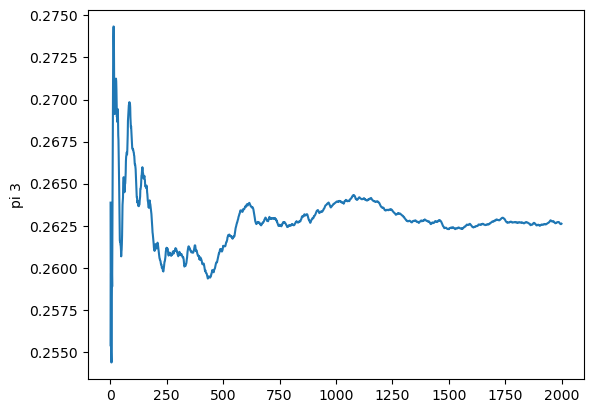

In [18]:
plt.plot(np.arange(S), running_average_pi[2,:])
plt.ylabel("pi 3")